In [35]:
import numpy as np
import scipy as sp
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline


from itertools import product

In [122]:
def get_energy_img(img, mask=None):
    weights = np.array([0.299, 0.587, 0.114])
    print(img.shape)
    brightness = img @ weights
    padded_img = np.pad(brightness, 2, 'edge')
    y_grads = (padded_img[2:] - padded_img[:-2])[1:-1, 2:-2]
    x_grads = (padded_img[:, 2:] - padded_img[:, :-2])[2:-2, 1:-1]
    energy = np.sqrt(y_grads ** 2 + x_grads ** 2)
    if mask is not None:
        energy += mask * energy.size * 256
    return energy


def build_dinamic_table(energy_img):
    dinamic_table = np.zeros([*energy_img.shape, 2])
    
    for j in range(energy_img.shape[1]):
        dinamic_table[0, j] = [energy_img[0, j], 0]
    for i, j in product(range(1, energy_img.shape[0]), range(0, energy_img.shape[1])):
        min_j = j + np.argmin(dinamic_table[i - 1, max(0, j - 1): min(energy_img.shape[1], j + 2), 0])
        if j != 0:
            min_j -= 1
        dinamic_table[i, j, 0] = energy_img[i, j] + dinamic_table[i - 1, min_j, 0]
        dinamic_table[i, j, 1] = min_j - j
    return dinamic_table


def find_min_curve(img, mask=None):
    dinamic_table = build_dinamic_table(get_energy_img(img, mask))
    min_curve = np.empty(img.shape[0], dtype=int)
    min_curve[-1] = np.argmin(dinamic_table[-1, :, 0])
    for i in range(img.shape[0] - 2, -1, -1):
        min_curve[i] = min_curve[i + 1] + dinamic_table[i + 1, min_curve[i + 1], 1]
    return min_curve

def delete_curve(img, curve):
    result = np.empty([img.shape[0], img.shape[1] - 1, img.shape[2]], dtype=img.dtype)
    for i, j in enumerate(curve):
        result[i] = np.concatenate([img[i,:j], img[i, j+1:]], axis=0)
    return result

def add_curve(img, curve):
    result = np.empty([img.shape[0], img.shape[1] + 1, img.shape[2]], dtype=img.dtype)
    for i, j in enumerate(curve):
        result[i] = np.concatenate([img[i,:j], [(img[i, j] + img[i, min(j + 1, img.shape[1])]) // 2], img[i, j:]], axis=0)
    return result

In [84]:
curve = find_min_curve(img)

In [95]:
shrinked_img = delete_curve(img, curve)

In [79]:
def plot_curve(img, curve):
    plt.figure(figsize=(16, 10))
    img = img.copy()
    for i, j in enumerate(curve):
        img[i, j] = [255, 255, 255]
    
    io.imshow(img)

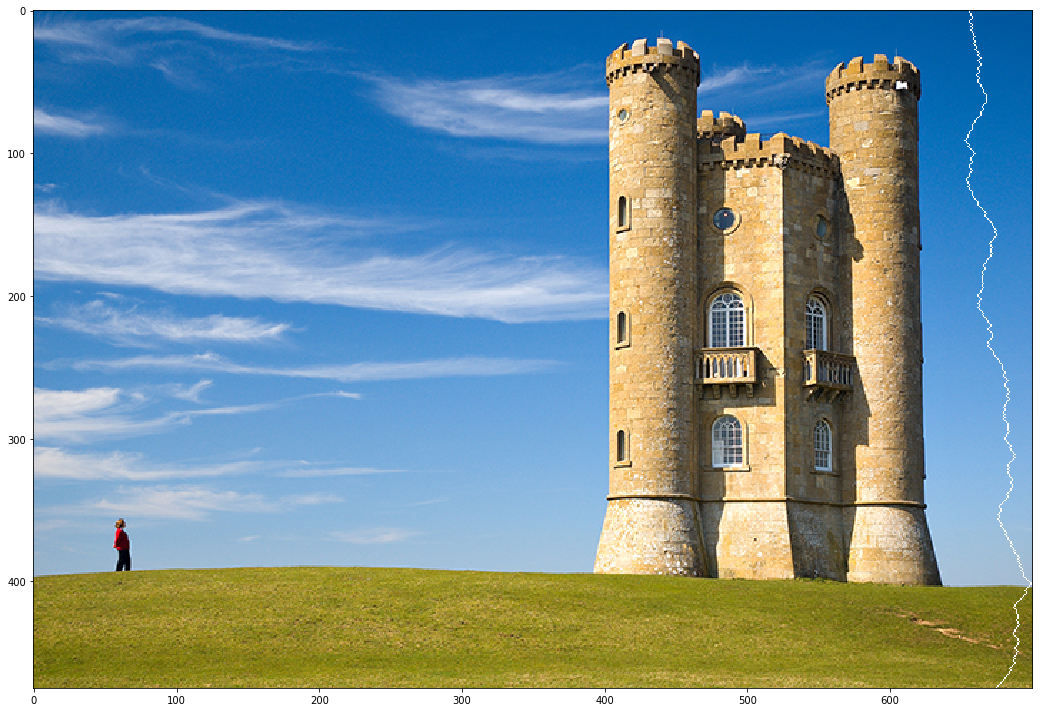

In [80]:
plot_curve(img, curve)

In [108]:
def shrink(img, iterations):
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.show()
    for i in tqdm(range(iterations + 1)):
        curve = find_min_curve(img)
        img = delete_curve(img, curve)
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.show()

In [106]:
img = io.imread('data/01_input/img.png')

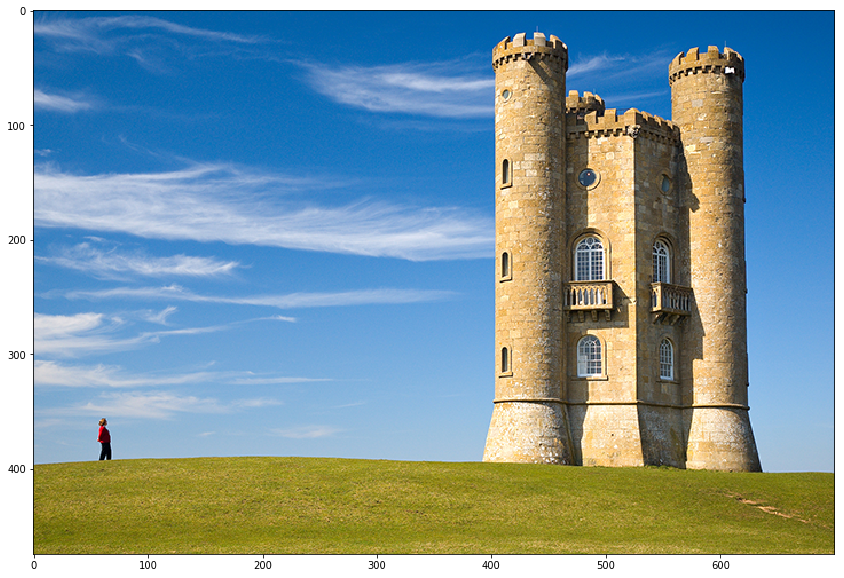

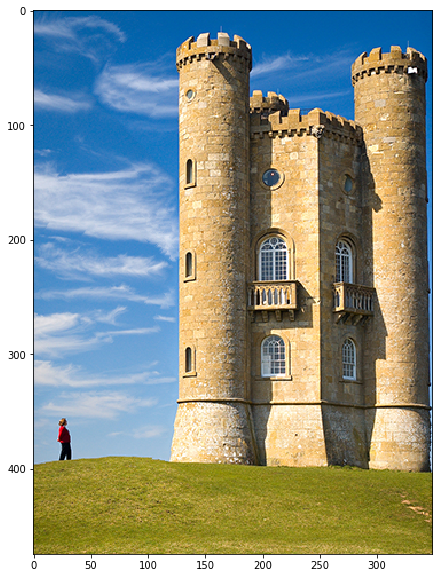

In [119]:
shrink(img, img.shape[1] // 2)

In [121]:
def seam_carve(img, mode, mask=None):
    if 'vertical' in mode:
        img = img.T
    
    curve = find_min_curve(img, mask)
    if 'shrink' in mode:
        result = delete_curve(img, curve)
    else:
        result = add_curve(img, curve)
    
    if 'vertical' in mode:
        img = img.T
        result = result.T
    
    return result